In [11]:
import sys
import os

from dotenv import load_dotenv
sys.path.insert(0, os.path.abspath('../src'))
sys.path.insert(0, os.path.abspath('../src/agents'))
print(sys.path)

load_dotenv()

['/Users/yannikhahn/Code/LLMsAgents-TextToSQL/src/agents', '/Users/yannikhahn/Code/LLMsAgents-TextToSQL/src', '/Users/yannikhahn/Code/LLMsAgents-TextToSQL/src/agents', '/Users/yannikhahn/Code/LLMsAgents-TextToSQL/src', '/Users/yannikhahn/Code/LLMsAgents-TextToSQL/evaulation/src', '/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/opt/homebrew/Cellar/python@3.12/3.12.6/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/yannikhahn/Library/Caches/pypoetry/virtualenvs/llmsagents-texttosql-JgGAmzxu-py3.12/lib/python3.12/site-packages']


True

In [12]:
import pandas as pd

sample = pd.read_csv("../sample/dev.csv")

sample.head()

,question_id,db_id,question,evidence,SQL,difficulty
0,479,card_games,Among the cards with converted mana cost highe...,card set Coldsnap refers to name = 'Coldsnap';...,SELECT SUM(CASE WHEN T1.power LIKE '*' OR T1.p...,moderate
1,1057,european_football_2,Calculate the average home team goal in the 20...,average home team goal = AVG(home_team_goal)= ...,SELECT CAST(SUM(t2.home_team_goal) AS REAL) / ...,moderate
2,1367,student_club,Which college do most of the members go to?,college most members go refers to MAX(COUNT(ma...,SELECT T2.college FROM member AS T1 INNER JOIN...,simple
3,298,toxicology,Calculate the percentage of molecules containi...,hydrogen refers to element = 'h'; label = '+' ...,SELECT CAST(COUNT(CASE WHEN T1.element = 'h' A...,moderate
4,651,codebase_community,"Provide the related post title of ""How to tell...",NaN,SELECT T3.Title FROM postLinks AS T1 INNER JOI...,simple


In [13]:
sample.count()

question_id    100
db_id          100
question       100
evidence        90
SQL            100
difficulty     100
dtype: int64

In [14]:
from langchain_ollama.chat_models import ChatOllama
from agents.feedback_agent import FeedbackAgent
from prompt_templates.feedback_agent import ONE_SHOT, TWO_SHOT

model_name = "claude-3-5-sonnet-latest"
#llm = ChatOllama(model="mistral")
agent = FeedbackAgent(template=ONE_SHOT)
model_type = "one_shot"

In [ ]:
from tqdm.notebook import tqdm
import os

os.makedirs(f"./runs/{model_name}", exist_ok=True)

start = 0

try:
    ongoing_run = pd.read_csv(f"./runs/{model_name}/{model_type}.csv").to_dict(orient="records")
    evaluation = ongoing_run
except:
    evaluation = []

for row in tqdm(
    sample[start:len(sample)].itertuples(index=False),
    total=len(sample),
    initial=start,
    desc=f"Evaluating {model_name}: ",
):
    response = agent._evaluate_query(
        database=row.db_id, original_question=row.question, generated_sql_query=row.SQL
    )
    if response:
        print(f"Difficulty: {row.difficulty} | Model Correct: {response["is_correct"]}")
        is_correct = response["is_correct"]
        successful_run = response["query_result"] != "error"
        feedback = response["feedback"]
    else:
        is_correct = False
        successful_run = False
        feedback = "LLM Failure"

    evaluation.append(
        {
            "question_id": row.question_id,
            "is_correct": is_correct,
            "difficulty": row.difficulty,
            "successful_run": successful_run,
            "feedback": feedback,
        }
    )
    df = pd.DataFrame(evaluation)
    df.to_csv(f"./runs/{model_name}/{model_type}.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: './runs/claude-3-5-sonnet-latest/one_shot.csv'

In [ ]:
accuracy = df["is_correct"].mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 67.00%


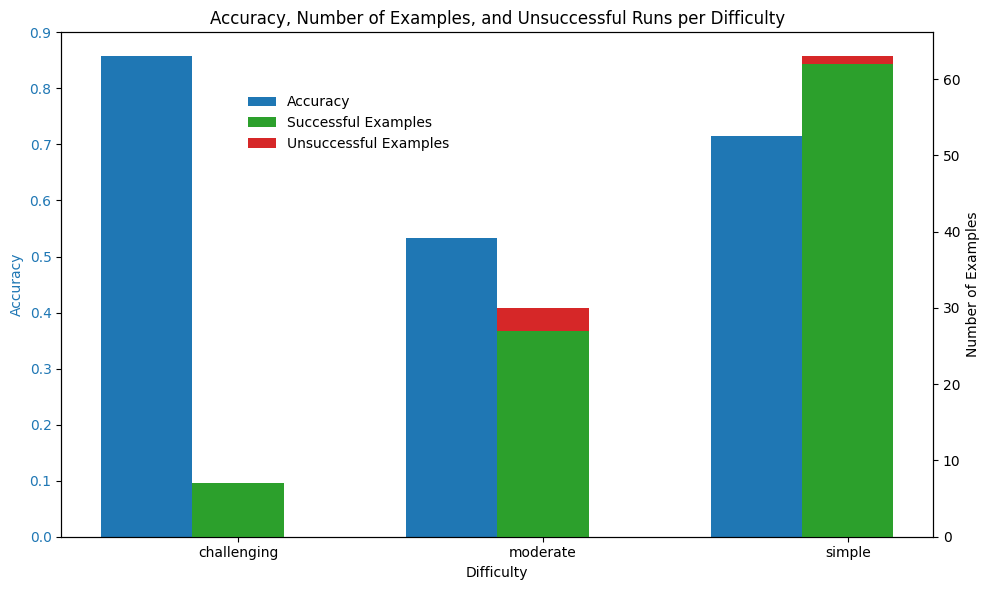

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure all indices align with sorted difficulties
difficulty_order = sorted(df["difficulty"].unique())

# Calculate metrics, ensuring alignment
accuracy_per_difficulty = (
    df.groupby("difficulty")["is_correct"]
    .mean()
    .reindex(difficulty_order, fill_value=0)
)
successful_examples = (
    df[df["successful_run"] == True]["difficulty"]
    .value_counts()
    .reindex(difficulty_order, fill_value=0)
)
unsuccessful_examples = (
    df[df["successful_run"] == False]["difficulty"]
    .value_counts()
    .reindex(difficulty_order, fill_value=0)
)

# Calculate total examples for consistency (or use successful + unsuccessful)
examples_per_difficulty = successful_examples + unsuccessful_examples

fig, ax1 = plt.subplots(figsize=(10, 6))  # Adjust figure size if needed

# Plot accuracy per difficulty
color = "tab:blue"
ax1.set_xlabel("Difficulty")
ax1.set_ylabel("Accuracy", color=color)
ax1.bar(
    difficulty_order,
    accuracy_per_difficulty,
    color=color,
    label="Accuracy",
    width=0.3,
    align="center",
)
ax1.tick_params(axis="y", labelcolor=color)

# Create a secondary y-axis to plot examples
ax2 = ax1.twinx()
ax2.set_ylabel("Number of Examples")

# Plot examples and unsuccessful runs per difficulty
width = 0.3  # Adjust bar width
positions = range(len(difficulty_order))  # Shared x-axis positions

# Stacked bar: successful and unsuccessful runs
ax2.bar(
    [p + width for p in positions],
    successful_examples,
    color="tab:green",
    label="Successful Examples",
    width=width,
    align="center",
)
ax2.bar(
    [p + width for p in positions],
    unsuccessful_examples,
    bottom=successful_examples,
    color="tab:red",
    label="Unsuccessful Examples",
    width=width,
    align="center",
)

# Customize tick positions and labels
ax1.set_xticks([p + width for p in positions])
ax1.set_xticklabels(difficulty_order)

ax1.grid(False)
ax2.grid(False)

# Adjust legend placement
fig.legend(
    loc="upper left",
    bbox_to_anchor=(0.2, 0.9),
    bbox_transform=ax1.transAxes,
    frameon=False,
)

# Add title
plt.title("Accuracy, Number of Examples, and Unsuccessful Runs per Difficulty")

# Save the figure
fig.savefig(f"runs/{model_name}/{model_type}.png")

fig.tight_layout()
plt.show()